# PMF for Recommender Systems

This is an implementation for Probabilistic Matrix Factorisation. We have made use of a subset of the IMDB dataset for training purposes.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.linalg import orthogonal_procrustes
from sklearn.metrics import mean_squared_error
from helpers_pmf import *

In [2]:
mu = 0.0 
sigma_u = 1.0
sigma_v = 1.0
sigma = 0.2 
parameters = {}
d_dims = 2 

In [3]:
realdata_df = pd.read_csv('data/ratings_per_user.csv')
realdata_df.head()

,user_hash,0071.jpg,0351.jpg,0428.jpg,0546.jpg,0001.jpg,0290.jpg,0527.jpg,0054.jpg,0652.jpg,...,0636.jpg,0409.jpg,0315.jpg,0741.jpg,0356.jpg,0650.jpg,0535.jpg,0382.jpg,0611.jpg,0128.jpg
0,2u7T5g3WNhXLNt8eXLm7iYrvR872,4.0,5.0,5.0,3.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3mHQgTNdhoXXOWEsJmHvbBuOxSb2,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4jQ4QWrm9SOsFMLIAajSZ5Usva82,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5HBSsBrc7LSwIQyRgTqY7Zf641f2,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,69AHmihCRKbJbXXM9GQ4FT7NSU32,5.0,4.0,2.0,5.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
ratings_matrix_df = realdata_df.set_index('user_hash')
ratings_matrix = ratings_matrix_df.values
n_users = ratings_matrix.shape[0]
n_items = ratings_matrix.shape[1]
ratings_matrix 

array([[4., 5., 5., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [4., 2., 3., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

We will now initialise our parameters. First the $V$ matrix can be initialised randomly using the following distribution:

\begin{equation}
\large
V \sim \mathcal N\left(0, \frac {1} {\lambda_V}\right)
\end{equation}

Let's remember that:

\begin{equation}
\large
U \in \mathbb R^{D\times N}, \qquad V \in \mathbb R^{D\times M}
\end{equation}

Where $N$ is __n_users__, $M$ is __n_movies__ and $D$ is __n_dims__.

In [5]:
def init_params_real_data(sigma_U, sigma_V, mu, sigma, d_dims, n_users, n_movies, ratings_matrix):    
    U_init = np.random.normal(mu, sigma_U, (d_dims, n_users))
    V_init = np.random.normal(mu, sigma_V, (d_dims, n_movies))    
    
    parameters['R'] = ratings_matrix
    parameters['U_result'] = U_init
    parameters['V_result'] = V_init
    parameters['lambda_U'] = sigma**2/sigma_U**2
    parameters['lambda_V'] = sigma**2/sigma_V**2

create __ratings__ dataframe and append rating matrix

In [43]:
def create_real_data_df(n_users, n_movies):   
    df = pd.DataFrame(columns=['userID', 'movieID'])

    df['userID'] = np.repeat(np.arange(1, n_users+1, 1), n_movies)
    df['movieID'] = np.tile(np.arange(1, n_movies+1, 1), n_users)     
    R = parameters['R']
    df['rating'] = R.reshape(n_users*n_movies)

    return df 

__split__ the dataset into train and test sets

In [44]:
def split_train_test(df, train_size=0.75):
    
    df_copy = df.copy()
    train_set = df_copy.sample(frac=train_size, random_state=0)
    test_set = df_copy.drop(train_set.index)
    
    return train_set, test_set
     

Let's now implement the function that updates U and V. The elements of both matrices can be updated using the following expressions:

\begin{equation}
\large
U_i=\left[\left(V_jV_j^T\right)_{j\in\Omega_{U_i}}+\lambda_UI\right]^{-1}\left(R_{ij}V_j^T\right)_{j\in\Omega_{U_i}}
\end{equation}

\begin{equation}
\large
V_j=\left[\left(U_iU_i^T\right)_{i\in\Omega_{V_j}}+\lambda_VI\right]^{-1}\left(R_{ij}U_i^T\right)_{i\in\Omega_{V_j}}
\end{equation}

In [45]:
def update_parameters(n_users, n_movies):
    U = parameters['U_result']
    V = parameters['V_result']
    R = parameters['R']
    lambda_U = parameters['lambda_U']
    lambda_V = parameters['lambda_V']

    for i in range(n_users):
        V_j = V[:, R[i, :] > 0]
        U[:, i] = np.dot(np.linalg.inv(np.dot(V_j, V_j.T) + lambda_U * np.identity(d_dims)), np.dot(R[i, R[i, :] > 0], V_j.T))
        #RV = R[i] @ V.T
        #print('RV:',RV.shape)
        #print('V.V^T:',np.dot(V,V.T).shape)
        
    for j in range(n_movies):
        U_i = U[:, R[:, j] > 0]
        V[:, j] = np.dot(np.linalg.inv(np.dot(U_i, U_i.T) + lambda_V * np.identity(d_dims)), np.dot(R[R[:, j] > 0, j], U_i.T))
        #RU = R[:, j] @ U.T
        #Uinv = np.linalg.inv(np.dot(U, U.T) + lambda_V * np.identity(d_dims))
        #V[:, j] = Uinv @ RU
 
    parameters['U_result'] = U
    parameters['V_result'] = V

Now let's implement the __Log-a posteriori__:

\begin{equation}
\large
L=-\frac 1 2 \left(\sum_{i=1}^N\sum_{j=1}^M(R_{ij}-U_i^TV_j)_{(i,j) \in \Omega_{R_{ij}}}^2+\lambda_U\sum_{i=1}^N\|U_i\|_{Fro}^2+\lambda_V\sum_{j=1}^M\|V_j\|_{Fro}^2\right)
\end{equation}

In [46]:
def log_a_posteriori():
    lambda_U = parameters['lambda_U']
    lambda_V = parameters['lambda_V']
    U_result = parameters['U_result']
    V_result = parameters['V_result']
    R = parameters['R']
    UV = np.dot(U_result.T, V_result)
    R_UV = (R[R > 0] - UV[R > 0])
    
    return -0.5 * (np.sum(np.dot(R_UV, R_UV.T)) + lambda_U * np.sum(np.dot(U_result, U_result.T)) + \
                   lambda_V * np.sum(np.dot(V_result, V_result.T)))


For the purposes of __scaling__, we need the maximum and minimum rating values.

In [47]:
def update_max_min_ratings():
    U = parameters['U_result']
    V = parameters['V_result']

    R = U.T @ V
    min_rating = np.min(R)
    max_rating = np.max(R)

    parameters['min_rating'] = min_rating
    parameters['max_rating'] = max_rating

The __predict__ function allows us to predict the rating value given the __user_id__ and the __movie_id__ parameters. The value has been scaled within the range 0-5

In [54]:
def predict(user_id, movie_id):
    U = parameters['U_result']
    V = parameters['V_result']
    user_id = int(user_id)
    movie_id = int(movie_id)
    r_ij = U[:, user_id-1].T.reshape(1, -1) @ V[:, movie_id-1].reshape(-1, 1) #user_id-1 shouled be changed
    max_rating = parameters['max_rating']
    min_rating = parameters['min_rating']

    return 0 if max_rating == min_rating else ((r_ij[0][0] - min_rating) / (max_rating - min_rating)) * 5.0

In [55]:
def frob(X, Y, N):
    return np.linalg.norm(X - Y, 'fro')/np.sqrt(N)

In [56]:
def compare_results(n_users, n_movies):
    R = parameters['R']
    U_result = parameters['U_result']
    V_result = parameters['V_result']
    
    R_result = U_result.T @ V_result
    diff_norm_R = frob(R, R_result , n_movies*n_users) 
    
    return diff_norm_R


The __evaluate__ function will calculate the __RMSE__ of the model given a dataset (train or test).

In [60]:
def evaluate(dataset):
    ground_truths = []
    predictions = []
    
    for index, row in dataset.iterrows():    
        ground_truths.append(row.loc['rating'])
        #print(index,row.loc['userID'])
        predictions.append(predict(row.loc['userID'], row.loc['movieID'])) 

    return mean_squared_error(ground_truths, predictions, squared=False)

The __train__ function implements the code necessary for training the model as well as recording the __RMSE__ values on the training and testing sets.

In [61]:
def train(n_epochs, train_set, test_set, n_users, n_movies):

    log_aps = []
    rmse_train = []
    rmse_test = []

    update_max_min_ratings()
    rmse_train.append(evaluate(train_set))
    rmse_test.append(evaluate(test_set))
    
    k = 0
    while True:
        if len(log_aps) > 2:
            if np.abs(log_aps[-1] - log_aps[-2]) < 0.0001:
                break
        update_parameters(n_users, n_movies)
        log_ap = log_a_posteriori()
        log_aps.append(log_ap)
        k += 1
        if (k + 1) % 25 == 0: 
            update_max_min_ratings()
            rmse_train.append(evaluate(train_set))
            rmse_test.append(evaluate(test_set))
            print('Log p a-posteriori at iteration', k + 1, ':', log_ap)

    update_max_min_ratings()
    diff_norm_R = compare_results(n_users, n_movies)
    return log_aps, rmse_train, rmse_test, diff_norm_R 

In [ ]:
d_vals = [2, 3, 4, 5, 6]#, 100]
data = []
np. set_printoptions(precision = 6)
print(sigma_u, sigma_v, sigma)
for i in range(len(d_vals)):
    print(f'i:{i}') 
    init_params_real_data(sigma_u/sigma, sigma_v/sigma, mu, sigma, d_dims, n_users, n_items, ratings_matrix)    
    df_ratings = create_real_data_df(n_users, n_items) 
    train_set, test_set = split_train_test(df_ratings, train_size=0.95)
    log_aps, rmse_train, rmse_test, diff_R = train(10, train_set, test_set, n_users, n_items) 

    row= [n_users, n_items, d_vals[i], diff_R, rmse_train[-1], rmse_test[-1]]
    print(row) # to check progress
    data.append(row)       

Let's train our model!

In [67]:
init_params_real_data(sigma_u/sigma, sigma_v/sigma, mu, sigma, d_dims, n_users, n_items, ratings_matrix)    
df_ratings = create_real_data_df(n_users, n_items) 
train_set, test_set = split_train_test(df_ratings, train_size=0.95)
log_aps, rmse_train, rmse_test, diff_R = train(10, train_set, test_set, n_users, n_items)   

Log p a-posteriori at iteration 25 : -347.86871452596495
Log p a-posteriori at iteration 50 : -333.54616222898625
Log p a-posteriori at iteration 75 : -325.41823726182645
Log p a-posteriori at iteration 100 : -320.03983365665016
Log p a-posteriori at iteration 125 : -316.2015661192943
Log p a-posteriori at iteration 150 : -313.3127372045029
Log p a-posteriori at iteration 175 : -311.04944384831475
Log p a-posteriori at iteration 200 : -309.2193709394803
Log p a-posteriori at iteration 225 : -307.7010358297745
Log p a-posteriori at iteration 250 : -306.4140386439126
Log p a-posteriori at iteration 275 : -305.30367483951994
Log p a-posteriori at iteration 300 : -304.3326419565017
Log p a-posteriori at iteration 325 : -303.47583964435603
Log p a-posteriori at iteration 350 : -302.7156801841607
Log p a-posteriori at iteration 375 : -302.03774090232696
Log p a-posteriori at iteration 400 : -301.42889397659144
Log p a-posteriori at iteration 425 : -300.8778323094025
Log p a-posteriori at ite

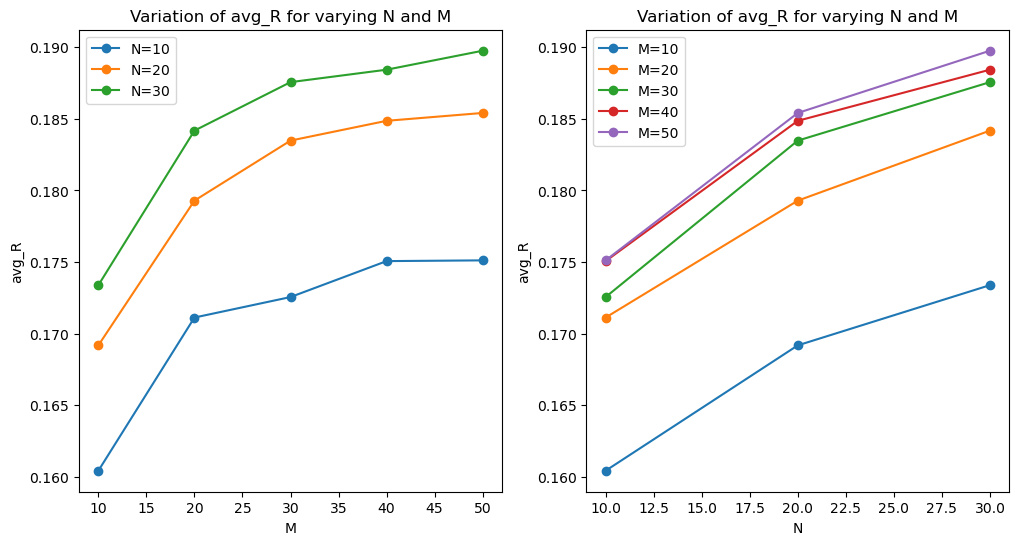

In [518]:
df = pd.DataFrame(data, columns = ['N', 'M', 'avg_R', 'avg_U', 'avg_V'])
#df.to_csv('results_optimization.csv')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
# plot as a function of M for avg_U and as a function of N fro avg_V

for n in df['N'].unique():
    df_m = df[df['N'] == n]
    ax1.plot(df_m['M'], df_m['avg_R'], marker='o', label=f'N={n}')

for m in df['M'].unique():
    df_n = df[df['M'] == m]
    ax2.plot(df_n['N'], df_n['avg_R'], marker='o', label=f'M={m}')

ax1.set_xlabel('M')
ax1.set_ylabel('avg_R')
ax1.set_title('Variation of avg_R for varying N and M')
ax1.legend()

ax2.set_xlabel('N')
ax2.set_ylabel('avg_R')
ax2.set_title('Variation of avg_R for varying N and M')
ax2.legend()

plt.show()

Now let's take a look at some graphs

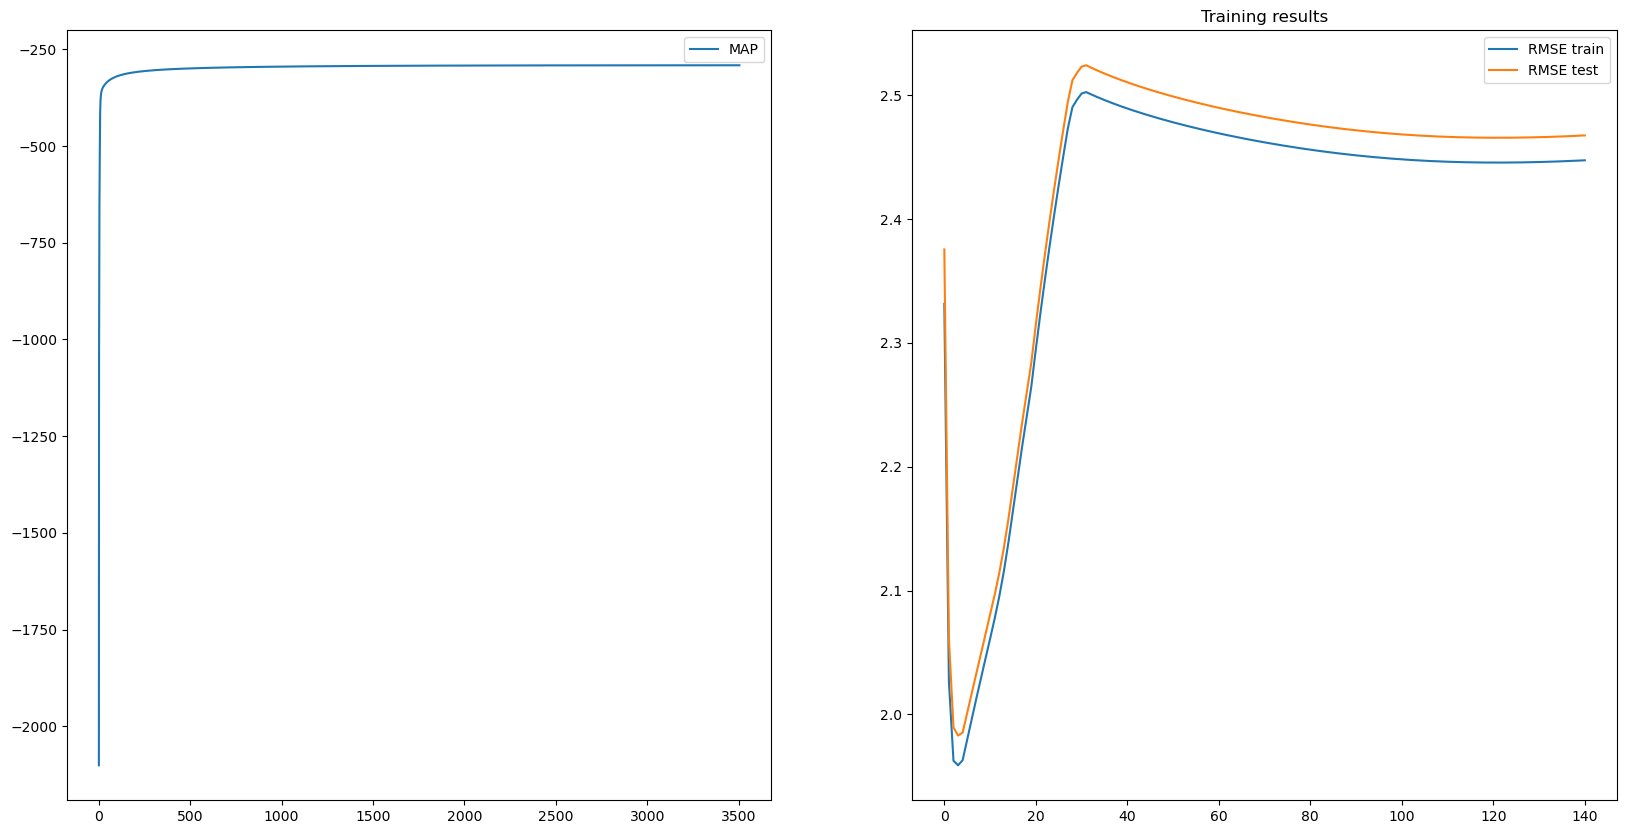

[2.3315107136118596, 2.0265240520812453, 1.9626600198871154, 1.9589888577116676, 1.9631013509113586, 1.9798470987973649, 1.9964822149000814, 2.0129616258862306, 2.02918804301975, 2.045155918784123, 2.0610618208329177, 2.077406305354937, 2.095090262077987, 2.115298485970387, 2.138685168623693, 2.1644041476125553, 2.1906760611841505, 2.216156705079185, 2.2403310569904393, 2.264379742106204, 2.2949010795526146, 2.3238911233784427, 2.3515152754325026, 2.3779099707272677, 2.4031887563834475, 2.4274475419286645, 2.4507685707677225, 2.473223302317647, 2.490398288252308, 2.4963974753680027, 2.501361486663939, 2.5025376681750533, 2.5008314765649824, 2.499197392451757, 2.497628005106721, 2.496117114714264, 2.4946594866214875, 2.4932506623219814, 2.4918868127419835, 2.490564623417586, 2.489281203953763, 2.48803401613945, 2.4868208165129126, 2.4856396102023735, 2.4844886136231676, 2.483366224172773, 2.4822709954851057, 2.481201617122449, 2.4801568978244974, 2.4791357516196646, 2.478137186247018, 2

In [68]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
plt.title('Training results')
ax1.plot(np.arange(len(log_aps)), log_aps, label='MAP')
ax1.legend()

ax2.plot(np.arange(len(rmse_train)), rmse_train, label='RMSE train')
ax2.plot(np.arange(len(rmse_test)), rmse_test, label='RMSE test')
ax2.legend()
plt.show()
print(rmse_train)

Let's now evaluate our model on both the training and testing sets.

In [69]:
print('RMSE of training set:', evaluate(train_set))
print('RMSE of testing set:', evaluate(test_set))

RMSE of training set: 2.447510720737315
RMSE of testing set: 2.467589149352373


Now we will pick a user from the database and look at his/her preferences.

In [66]:
user_id = 45
df[df['user_id'] == user_id].sort_values(by=['rating'], ascending=False).head(10)

NameError: name 'df' is not defined

Let's look at the least preferred items.

In [ ]:
df_join[df_join['userId'] == user_id].sort_values(by=['rating']).head(10)

Let's now look at the most likely preferences of the selected user.

In [ ]:
predictions = np.zeros((n_movies, 1))
movie_to_column_items = np.array(list(movie_to_column.items()))
df_result = pd.DataFrame(columns=['UserID', 'MovieID', 'Movie', 'Genres', 'Prediction'])

for i, movie in enumerate(movie_to_column_items):
    predictions[i] = predict(user_id, movie[0])
    
indices = np.argsort(-predictions, axis=0)

for j in range(10):
    movie_id = int(movie_to_column_items[np.where(movie_to_column_items[:, 1] == indices[j])][0][0])
    df_row = pd.DataFrame({
        'UserID': user_id,
        'MovieID': movie_id,
        'Movie': df_movies[df_movies['movieId'] == movie_id].iloc[0]['title'],
        'Genres': df_movies[df_movies['movieId'] == movie_id].iloc[0]['genres'],
        'Prediction': predictions[indices[j]][0][0]
    }, index=[j])
    df_result = df_result.append(df_row, sort=False)
    
df_result

Now the predictions for least preferred items.

In [ ]:
df_result = pd.DataFrame(columns=['UserID', 'MovieID', 'Movie', 'Genres', 'Prediction'])
indices = np.argsort(predictions, axis=0)

for j in range(10):
    movie_id = int(movie_to_column_items[np.where(movie_to_column_items[:, 1] == indices[j])][0][0])
    df_row = pd.DataFrame({
        'UserID': user_id,
        'MovieID': movie_id,
        'Movie': df_movies[df_movies['movieId'] == movie_id].iloc[0]['title'],
        'Genres': df_movies[df_movies['movieId'] == movie_id].iloc[0]['genres'],
        'Prediction': predictions[indices[j]][0][0]
    }, index=[j])
    df_result = df_result.append(df_row, sort=False)
    
df_result

I hope you enjoyed this exercise. Something you can also try on your own is to implement gradient descent instead of MAP-estimation like I did here. Let me know about any comments you may have.